In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Neural Process for 1D functions

This notebook shows how to train and sample from a Neural Process for a simple class of 1D functions. The functions are defined by f(x) = a * sin(x - b) where a and b and randomly sampled.

### Visualize Data

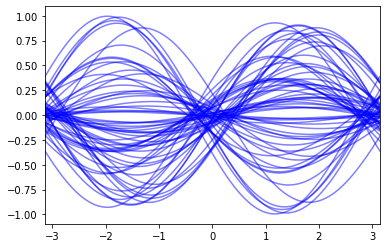

In [2]:
from datasets import SineData
from math import pi

# Create dataset
dataset = SineData(amplitude_range=(-1., 1.),
                   shift_range=(-.5, .5),
                   num_samples=2000)

# Visualize data samples
for i in range(64):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Build Neural Process

In [3]:
from neural_process import NeuralProcess
from encoder import MLPEncoder
from aggregator import MeanAggregator
from latent_distribution import NormalLatentDistribution
from decoder import MLPDecoder

BATCH_SIZE = 32
X_DIM = 1
Y_DIM = 1
N = 4
M = 2
R_DIM = 20
S_DIM = (20, 2)
H_DIM = 20
Z_DIM = 20

neuralprocess = NeuralProcess(MLPEncoder(X_DIM, Y_DIM, R_DIM, H_DIM),
                    MeanAggregator(X_DIM, R_DIM),
                    MLPEncoder(X_DIM, Y_DIM, S_DIM, H_DIM),
                    MeanAggregator(X_DIM, S_DIM),
                    NormalLatentDistribution(Z_DIM, S_DIM),
                    MLPDecoder(X_DIM, R_DIM, Z_DIM, Y_DIM, H_DIM)
)

### Visualize samples from prior

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

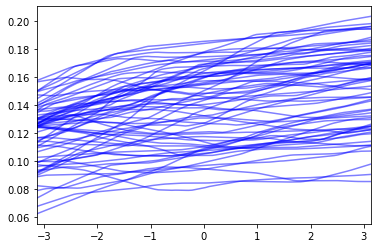

In [4]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    batch_size = 1
    z_sample = torch.randn((batch_size, Z_DIM))  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    r_c = torch.zeros(batch_size, R_DIM, 1)
    mu = neuralprocess.decoder(x_target, r_c, z_sample).mean
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Train Neural Process

In [5]:
from torch.utils.data import DataLoader
from train import train

num_context = 4
num_target = 4

data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
train(device, neuralprocess, optimizer, data_loader, 30, (4,4), (4,4))

  0%|          | 0/1890 [00:00<?, ?it/s]

defaultdict(list,
            {'training.loss': [(0, tensor(7.1625, grad_fn=<AddBackward0>)),
              (1, tensor(5.8665, grad_fn=<AddBackward0>)),
              (2, tensor(6.3038, grad_fn=<AddBackward0>)),
              (3, tensor(6.7352, grad_fn=<AddBackward0>)),
              (4, tensor(5.7787, grad_fn=<AddBackward0>)),
              (5, tensor(5.7680, grad_fn=<AddBackward0>)),
              (6, tensor(6.0946, grad_fn=<AddBackward0>)),
              (7, tensor(6.6993, grad_fn=<AddBackward0>)),
              (8, tensor(7.0938, grad_fn=<AddBackward0>)),
              (9, tensor(7.0214, grad_fn=<AddBackward0>)),
              (10, tensor(5.4734, grad_fn=<AddBackward0>)),
              (11, tensor(5.8002, grad_fn=<AddBackward0>)),
              (12, tensor(5.5086, grad_fn=<AddBackward0>)),
              (13, tensor(6.2527, grad_fn=<AddBackward0>)),
              (14, tensor(6.5153, grad_fn=<AddBackward0>)),
              (15, tensor(6.4834, grad_fn=<AddBackward0>)),
              (

### Visualize samples from trained prior

The prior should now encode some information about the shapes of the functions.

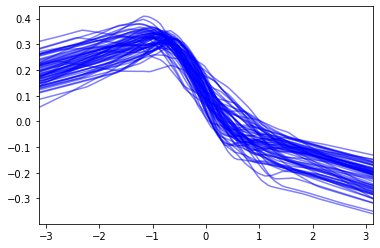

In [6]:
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    batch_size = 1
    z_sample = torch.randn((1, Z_DIM))
    r_c = torch.zeros(batch_size, R_DIM, 1)
    mu = neuralprocess.decoder(x_target, torch.zeros((batch_size, R_DIM, 1)), z_sample).mean
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Visualize samples from posterior

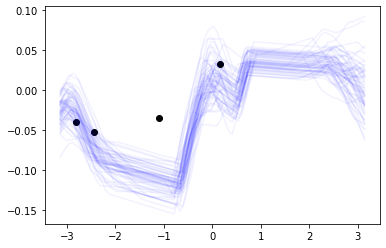

In [7]:
from util import context_target_split

for batch in data_loader:
    break
# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess.training = False

for i in range(64):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='b')

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')